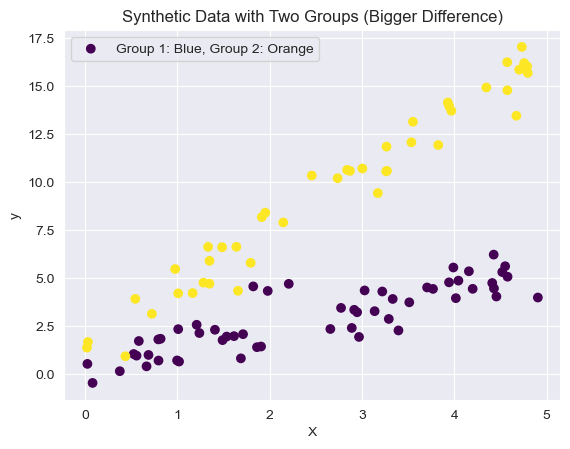

Epoch 0/4000, Loss: 3988335.25
Epoch 100/4000, Loss: 1248119.0
Epoch 200/4000, Loss: 99404.25
Epoch 300/4000, Loss: 59033.75
Epoch 400/4000, Loss: 205618.171875
Epoch 500/4000, Loss: 255978.3125
Epoch 600/4000, Loss: 158374.84375
Epoch 700/4000, Loss: 169381.59375
Epoch 800/4000, Loss: 68445.375
Epoch 900/4000, Loss: 95447.140625
Epoch 1000/4000, Loss: 15507.767578125
Epoch 1100/4000, Loss: 18898.068359375
Epoch 1200/4000, Loss: 33655.640625
Epoch 1300/4000, Loss: 12464.919921875
Epoch 1400/4000, Loss: 13069.900390625
Epoch 1500/4000, Loss: 34338.48828125
Epoch 1600/4000, Loss: 38559.76953125
Epoch 1700/4000, Loss: 12690.4560546875
Epoch 1800/4000, Loss: 14772.9345703125
Epoch 1900/4000, Loss: 16160.1669921875
Epoch 2000/4000, Loss: 26056.41015625
Epoch 2100/4000, Loss: 35793.74609375
Epoch 2200/4000, Loss: 7589.1376953125
Epoch 2300/4000, Loss: 29029.5
Epoch 2400/4000, Loss: 20017.94921875
Epoch 2500/4000, Loss: 10278.4560546875
Epoch 2600/4000, Loss: 8317.458984375
Epoch 2700/4000, L

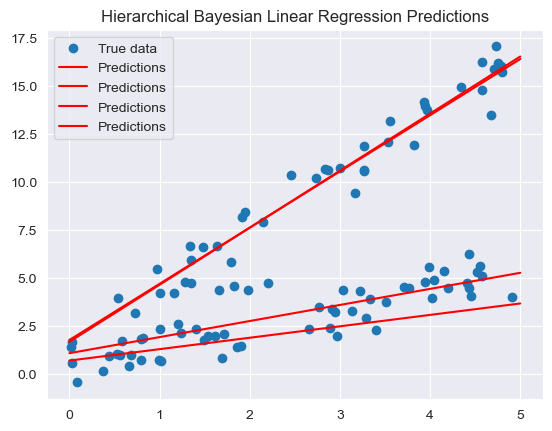

True Slope Group 1: 3.0, Learned Slope Group 1: 4.858386039733887
True Intercept Group 1: 1.5, Learned Intercept Group 1: 2.767570972442627
True Slope Group 2: 1.0, Learned Slope Group 2: 2.7876861095428467
True Intercept Group 2: 0.5, Learned Intercept Group 2: 1.894941806793213


In [43]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

# Generate synthetic data with two groups
torch.manual_seed(42)
num_samples = 100
X = torch.rand(num_samples, 1) * 5

# Define true parameters for each group with a bigger difference
true_slope_group1, true_intercept_group1 = 3.0, 1.5
true_slope_group2, true_intercept_group2 = 1.0, 0.5

# Assign samples to groups
group_indicator = torch.randint(2, (num_samples, 1))

# Generate corresponding y values based on group assignments
y = group_indicator * (true_slope_group1 * X + true_intercept_group1) + (1 - group_indicator) * (true_slope_group2 * X + true_intercept_group2) + torch.randn_like(X)

# Plot the generated data
plt.scatter(X.numpy(), y.numpy(), c=group_indicator.numpy(), cmap='viridis', label='Group 1: Blue, Group 2: Orange')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Data with Two Groups (Bigger Difference)')
plt.legend()
plt.show()

# Define Bayesian Linear Regression model with partial pooling
class HierarchicalBayesianLinearRegression(nn.Module):
    def __init__(self):
        super(HierarchicalBayesianLinearRegression, self).__init__()

        # Shared parameters
        self.weight_rho_global = nn.Parameter(torch.randn(1))
        self.weight_mu_group = nn.Parameter(torch.randn(2))
        self.weight_rho_group = nn.Parameter(torch.randn(2))

        self.bias_rho_global = nn.Parameter(torch.randn(1))
        self.bias_mu_group = nn.Parameter(torch.randn(2))
        self.bias_rho_group = nn.Parameter(torch.randn(2))

        self.normal = Normal(0, 1)

    def forward(self, x, group_indicator):
        weight_epsilon_global = self.normal.sample(self.weight_rho_global.size())
        bias_epsilon_global = self.normal.sample(self.bias_rho_global.size())
        weight_global = self.weight_rho_global + torch.log(1 + torch.exp(self.weight_rho_global)) * weight_epsilon_global
        bias_global = self.bias_rho_global + torch.log(1 + torch.exp(self.bias_rho_global)) * bias_epsilon_global

        weight_epsilon_group = self.normal.sample(self.weight_rho_group.size())
        bias_epsilon_group = self.normal.sample(self.bias_rho_group.size())
        weight_group = self.weight_mu_group[group_indicator] + torch.log(1 + torch.exp(self.weight_rho_group[group_indicator])) * weight_epsilon_group
        bias_group = self.bias_mu_group[group_indicator] + torch.log(1 + torch.exp(self.bias_rho_group[group_indicator])) * bias_epsilon_group

        return x * weight_group + bias_group + x * weight_global + bias_global

def kl_divergence(rho, mu):
    return 0.5 * torch.sum(1 + torch.log1p(torch.exp(2 * rho)) - mu.pow(2) - torch.exp(2 * rho))
    # return -0.5 * torch.sum(1 + rho - mu.pow(2) - rho.exp())

# SVI for Hierarchical Bayesian Linear Regression with Visualization
def svi_hierarchical_bayesian_regression_visualize(model, X, y, group_indicator, num_epochs=4000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X, group_indicator)

        # Compute negative log-likelihood as the loss
        log_likelihood = -Normal(y_pred, 0.1).log_prob(y).sum()
        kl_divergence = 0.5 * torch.sum(1 + torch.log(1e-8 + torch.exp(2 * model.weight_rho_global)) - model.weight_rho_global.pow(2) - torch.exp(2 * model.weight_rho_global))
        kl_divergence += 0.5 * torch.sum(1 + torch.log(1e-8 + torch.exp(2 * model.bias_rho_global)) - model.bias_rho_global.pow(2) - torch.exp(2 * model.bias_rho_global))
        kl_divergence += 0.5 * torch.sum(1 + torch.log(1e-8 + torch.exp(2 * model.weight_rho_group)) - model.weight_rho_group.pow(2) - torch.exp(2 * model.weight_rho_group))
        kl_divergence += 0.5 * torch.sum(1 + torch.log(1e-8 + torch.exp(2 * model.bias_rho_group)) - model.bias_rho_group.pow(2) - torch.exp(2 * model.bias_rho_group))
        loss = log_likelihood + kl_divergence
        losses.append(loss.item())

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

    # Plotting predictions
    with torch.no_grad():
        model.eval()
        X_test = torch.linspace(0, 5, 100).unsqueeze(1)
        group1 = torch.zeros_like(X_test, dtype=torch.long)  # Convert to long type
        group2 = torch.ones_like(X_test, dtype=torch.long)  # Convert to long type
        y_pred_test1 = model(X_test, group1)
        y_pred_test2 = model(X_test, group2)

        plt.scatter(X.numpy(), y.numpy(), label='True data')
        plt.plot(X_test.numpy(), y_pred_test1.numpy(), label='Predictions', color='red')
        plt.plot(X_test.numpy(), y_pred_test2.numpy(), label='Predictions', color='red')
        
        plt.title('Hierarchical Bayesian Linear Regression Predictions')
        plt.legend()
        plt.show()

    return losses


# Instantiate the Hierarchical Bayesian Linear Regression model
hierarchical_model = HierarchicalBayesianLinearRegression()

# Train the model using SVI with visualization
losses = svi_hierarchical_bayesian_regression_visualize(hierarchical_model, X, y, group_indicator)

# Get the learned parameters
learned_slope_group1 = hierarchical_model.weight_mu_group[1].item()
learned_slope_group2 = hierarchical_model.weight_mu_group[0].item()
learned_intercept_group1 = hierarchical_model.bias_mu_group[1].item()
learned_intercept_group2 = hierarchical_model.bias_mu_group[0].item()

print(f'True Slope Group 1: {true_slope_group1}, Learned Slope Group 1: {learned_slope_group1}')
print(f'True Intercept Group 1: {true_intercept_group1}, Learned Intercept Group 1: {learned_intercept_group1}')
print(f'True Slope Group 2: {true_slope_group2}, Learned Slope Group 2: {learned_slope_group2}')
print(f'True Intercept Group 2: {true_intercept_group2}, Learned Intercept Group 2: {learned_intercept_group2}')


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Generate synthetic time-series data
torch.manual_seed(42)
time_steps = torch.linspace(0, 10, 100)
X = torch.sin(time_steps) + torch.randn(100) * 0.1  # Sinusoidal data with noise
X = X.unsqueeze(1).unsqueeze(2)  # Reshape for LSTM input
y = torch.roll(X, -1, 0)  # Target is next value in sequence

# Bayesian LSTM Model
class BayesianLSTM(nn.Module):
    def __init__(self, hidden_size):
        super(BayesianLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, 1)
        self.fc_rho = nn.Linear(hidden_size, 1)
        self.normal = Normal(0, 1)

    def forward(self, x):
        outputs, _ = self.lstm(x)
        last_output = outputs[:, -1, :]

        # Sample weights
        fc_epsilon = self.normal.sample(self.fc_mu.weight.size())
        fc_weight = self.fc_mu.weight + torch.log(1 + torch.exp(self.fc_rho.weight)) * fc_epsilon
        fc_bias = self.fc_mu.bias

        # Apply the linear layer
        prediction = torch.matmul(last_output, fc_weight.t()) + fc_bias
        return prediction

# SVI for Bayesian LSTM
def svi_bayesian_lstm(model, X, y, num_epochs=30000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X)[:-1]  # Ignore the last prediction, as it has no corresponding target
        y_true = y[1:]  # Ignore the first target, as it has no corresponding input

        # Compute negative log-likelihood as the loss
        log_likelihood = -Normal(y_pred, 0.1).log_prob(y_true).sum()
        kl_divergence = sum(0.5 * torch.sum(1 + torch.log(1e-8 + torch.exp(2 * p)) - p.pow(2) - torch.exp(2 * p))
                            for p in model.fc_rho.parameters())
        loss = log_likelihood + kl_divergence

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Instantiate the Bayesian LSTM model
bayesian_lstm = BayesianLSTM(hidden_size=10)

# Train the model using SVI
svi_bayesian_lstm(bayesian_lstm, X, y)

# Evaluate the model
with torch.no_grad():
    predictions = bayesian_lstm(X)[:-1]
    # You can now compare 'predictions' with 'y[1:]' to evaluate the model
    

Epoch 0/30000, Loss: 218229.625
Epoch 100/30000, Loss: 214485.65625
Epoch 200/30000, Loss: 214885.609375
Epoch 300/30000, Loss: 214504.671875
Epoch 400/30000, Loss: 214437.34375
Epoch 500/30000, Loss: 214450.65625
Epoch 600/30000, Loss: 214447.28125
Epoch 700/30000, Loss: 214407.796875
Epoch 800/30000, Loss: 214399.984375
Epoch 900/30000, Loss: 214386.859375
Epoch 1000/30000, Loss: 214355.9375
Epoch 1100/30000, Loss: 214335.359375
Epoch 1200/30000, Loss: 214316.15625
Epoch 1300/30000, Loss: 214295.171875
Epoch 1400/30000, Loss: 214271.25
Epoch 1500/30000, Loss: 214240.0625
Epoch 1600/30000, Loss: 214202.765625
Epoch 1700/30000, Loss: 214157.046875
Epoch 1800/30000, Loss: 214099.453125
Epoch 1900/30000, Loss: 214029.640625
Epoch 2000/30000, Loss: 213945.5
Epoch 2100/30000, Loss: 213847.21875
Epoch 2200/30000, Loss: 213737.453125
Epoch 2300/30000, Loss: 213609.890625
Epoch 2400/30000, Loss: 213458.34375
Epoch 2500/30000, Loss: 213282.203125
Epoch 2600/30000, Loss: 213079.953125
Epoch 270